In [184]:
!pip install transformers==4.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [185]:
import numpy as np

import torch
import torchvision
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import get_linear_schedule_with_warmup

In [186]:
def Gaussian_noise(img):
    sigma = 0.5
    out = img + sigma * torch.randn_like(img)
    return out

In [187]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/content', train=True, download=True,
  transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()])),
  batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/content', train=False, download=True,
  transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()])),
  batch_size=1024, shuffle=True)

In [188]:
len(train_loader)

1875

In [189]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [190]:
example_data.shape

torch.Size([1024, 1, 28, 28])

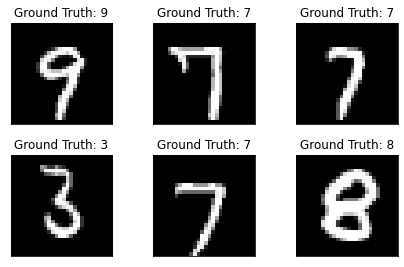

In [191]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

Noise version


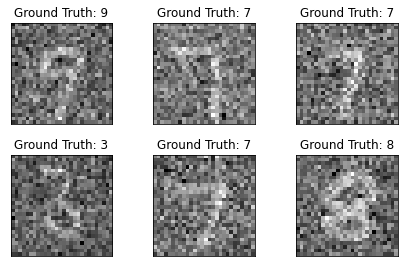

In [192]:
print("Noise version")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(Gaussian_noise(example_data[i][0]), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [193]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), 
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),   
            nn.ReLU()
            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [194]:
num_epochs = 100

# Warm up
warm_up_ratio = 0.1
step = len(train_loader)
total_step = num_epochs * step

model = conv_autoencoder()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warm_up_ratio * total_step, num_training_steps = total_step)

In [195]:
best_loss = np.inf
model.train()

for epoch in range(num_epochs):
    tot_loss = list()
    for data, target in train_loader:

        # ===================loading=====================
        img = data.cuda()
        noise_img = Gaussian_noise(img)
        # ===================forward=====================
        output = model(noise_img)
        loss = F.mse_loss(output, img)
        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_cnn.pt')
    # ===================log========================
    print(f"Epoch {epoch + 1:.0f}/{num_epochs:.0f} | loss = {mean_loss:.7f}")

Epoch 1/100 | loss = 0.2257238
Epoch 2/100 | loss = 0.0330097
Epoch 3/100 | loss = 0.0207246
Epoch 4/100 | loss = 0.0159741
Epoch 5/100 | loss = 0.0135126
Epoch 6/100 | loss = 0.0121834
Epoch 7/100 | loss = 0.0114091
Epoch 8/100 | loss = 0.0108987
Epoch 9/100 | loss = 0.0105945
Epoch 10/100 | loss = 0.0103519
Epoch 11/100 | loss = 0.0101490
Epoch 12/100 | loss = 0.0099594
Epoch 13/100 | loss = 0.0098229
Epoch 14/100 | loss = 0.0096906
Epoch 15/100 | loss = 0.0095832
Epoch 16/100 | loss = 0.0095158
Epoch 17/100 | loss = 0.0094444
Epoch 18/100 | loss = 0.0093703
Epoch 19/100 | loss = 0.0092898
Epoch 20/100 | loss = 0.0092470
Epoch 21/100 | loss = 0.0091985
Epoch 22/100 | loss = 0.0091666
Epoch 23/100 | loss = 0.0091076
Epoch 24/100 | loss = 0.0090644
Epoch 25/100 | loss = 0.0090304
Epoch 26/100 | loss = 0.0089915
Epoch 27/100 | loss = 0.0089802
Epoch 28/100 | loss = 0.0089675
Epoch 29/100 | loss = 0.0089199
Epoch 30/100 | loss = 0.0088886
Epoch 31/100 | loss = 0.0088686
Epoch 32/100 | lo

In [202]:
# load trained model
checkpoint_path = 'best_model_cnn.pt'
model = torch.load(checkpoint_path)
model.eval()

conv_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()

Before


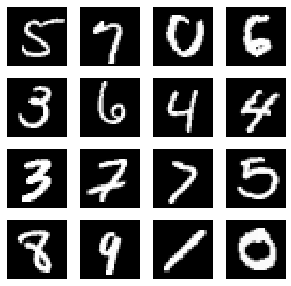

Add Noise


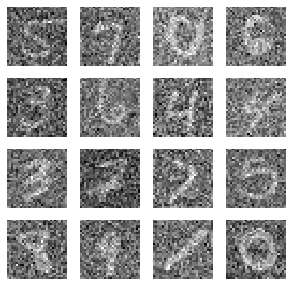

After


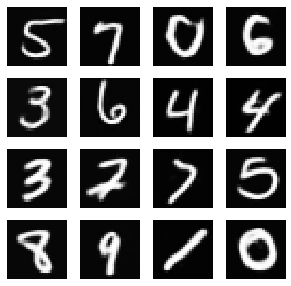

In [209]:
# Show images
def show_images(images):
    plt.figure(figsize=(5,5))
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.cpu().reshape(28, 28), cmap='gray', interpolation='none')
        plt.axis('off')


with torch.no_grad():
  for i, (data, target) in enumerate(test_loader):

        img = data.cuda()
        noise_img = Gaussian_noise(img)
        output = model(noise_img)

        print('Before')
        show_images(img[:16])
        plt.show()
        
        print('Add Noise')
        show_images(noise_img[:16])
        plt.show()

        print('After')
        show_images(output[:16])
        plt.show()
        break